First we import our dependencies.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam as adam
from tensorflow.keras import backend
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import glob
from itertools import product as myzip

We import our data into a dictionary, the keys of which describe the splitting.

In [7]:
my_path = 'D:\s4353631\keras_png_slices_data\keras_png_slices_'
datasets = ['train', 'validate', 'test']
pixels = [0, 85, 170, 255]
data_dict = {}

In [10]:
def format_fn(path):
    '''
    Formats single-channel image (.png) at path as a tf.Tensor of shape suitable 
    for input to a CNN.
    
    Args:
        path (str): Image filepath.
        
    Returns:
        tf.Tensor: formatted tensor representing the image.
    '''
    img = tf.io.read_file(path)
    tens = tf.image.decode_png(img)
    
    return tf.reshape(tens, [256, 256, 1])

def path_2_tens(x_path, y_path, pixels=pixels):
    '''
    Formats x and y single-channel images (.png) as tf.Tensors of shape suitable 
    for input to a CNN. Formatting of y images is performed by separating the pixel 
    values in pixels into discrete Boolean channels along the depth axis.
    
    Args:
        x_path (str): x image (raw input) filepath.
        y_path (str): y image (raw input) filepath.
        
    Returns:
        x (tf.Tensor): Formatted tensor representing the x image.
        y (tf.Tensor): Formatted tensor of Boolean channels representing the y image.
    '''
    x = format_fn(x_path)
    x = tf.cast(x, tf.float32)/127.5 - 1.0
    
    y = format_fn(y_path)
    y = tf.reshape(y, [256, 256])
    y = tf.stack([y==pixel for pixel in pixels], axis=2)
    y = tf.cast(y, tf.float32)
    
    return x, y

In [12]:
# Create the datasets for each element of the datasets list (train, validate, test), 
# storing them in data_dict.
for dataset in datasets:
    # Extract the x and y image titles; we know these to match and could generate them
    # from a single glob.glob if preferred. However, this method is useful as it allows 
    # us to check that no images are missing.
    x_paths = glob.glob(my_path + dataset + '/*.png')
    y_paths = glob.glob(my_path + 'seg_' + dataset + '/*.png')
    # Create a tf.data.Dataset from the image filepaths.
    data_dict[dataset] = tf.data.Dataset.from_tensor_slices((x_paths, y_paths))
    # Shuffle each dataset at each iteration to prevent data leakage, choosing a large 
    # Shuffling index to safeguard against only shuffling a small portion.
    data_dict[dataset] = data_dict[dataset].shuffle(10**5, reshuffle_each_iteration=True)
    # Apply the path_2_tens map, filling out the datasets.
    data_dict[dataset] = data_dict[dataset].map(path_2_tens)

Let's take a quick look to check things worked correctly.

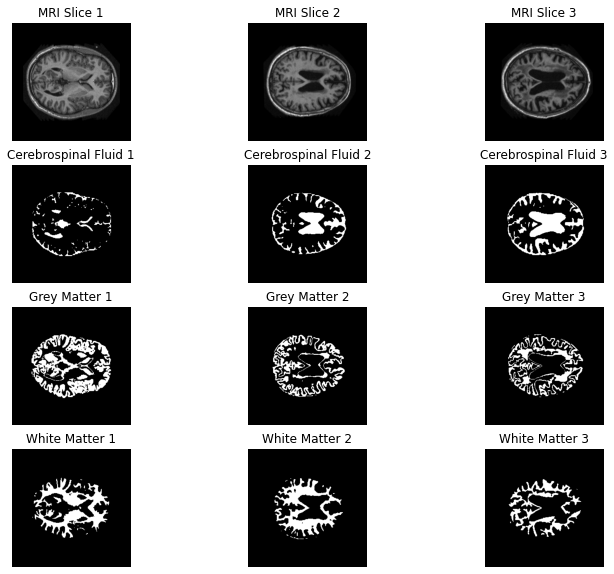

In [17]:
# Extract three samples from the training set using an iterator.
x_sample, y_sample = next(iter(data_dict['train'].batch(3)))
# The samples contain each image in the first dimension, the two pixel  
# axes in the second and third dimensions and the channels in the
# fourth dimension. Here we do not require the channel on the x image.
x_sample = tf.reshape(x_sample, [3, 256, 256])

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
labels = ['Cerebrospinal Fluid ', 'Grey Matter ', 'White Matter ']

# For each sample we plot the x image as well as each formatted channel 
# of the y image, making use of the product function from itertools 
# (here renamed myzip in comparison with the standard zip tool).
for i, j in myzip(range(3), range(1, 4)):
    ax[0][i].imshow(x_sample[i], cmap='gray')
    ax[0][i].axis('off')
    ax[0][i].set_title('MRI Slice ' + str(i+1))
    
    ax[j][i].imshow(y_sample[i, :, :, j], cmap='gray')
    ax[j][i].axis('off')
    ax[j][i].set_title(labels[j-1] + str(i+1))
    
plt.show()